## THIS NOTEBOOK AIMS TO USING A TIMM MODEL TO PREDICT THE PRESENCE OF WATER IN A SATELLITE IMAGE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torchvision.transforms as transforms
import numpy as np

from PIL import Image

# data from here https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies

#images_path = "./data/Water Bodies Dataset/Images"
#masks_path = "./data/Water Bodies Dataset/Masks"

images_path = "/content/drive/MyDrive/Data/Water Bodies Dataset/Images"
masks_path = "/content/drive/MyDrive/Data/Water Bodies Dataset/Masks"

IMAGES_WITH = 128
IMAGES_HEIGHT = 128

transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize((IMAGES_WITH, IMAGES_HEIGHT), antialias=True)
])

def format_image(path):
    image = Image.open(path)
    image = transform(image)
    image = image / 255
    image = image.float()
    return image.numpy()

def format_mask(path):
    mask = Image.open(path)
    mask = transform(mask)
    mask = mask[0]
    mask = mask / 255
    mask = mask.reshape(IMAGES_WITH * IMAGES_HEIGHT)
    return mask.numpy()

images = []
masks = []
for path in os.listdir(images_path):
    images.append(format_image(images_path + "/" + path))
    masks.append(format_mask(masks_path + "/" + path))

images = np.array(images, dtype='float32')
masks = np.array(masks, dtype='float32')

print("dataset size")
print(images.shape)
print(masks.shape)

split = 0.8

images_train = images[:int(images.shape[0]*split)]
masks_train = masks[:int(masks.shape[0]*split)]

print("train size")
print(images_train.shape)
print(masks_train.shape)

images_val = images[int(images.shape[0]*split):]
masks_val = masks[int(masks.shape[0]*split):]

print("validation size")
print(images_val.shape)
print(masks_val.shape)

dataset size
(2841, 3, 128, 128)
(2841, 16384)
train size
(2272, 3, 128, 128)
(2272, 16384)
validation size
(569, 3, 128, 128)
(569, 16384)


In [4]:
import timm

model = timm.create_model(
    'resnet50d',
    pretrained=True,
    in_chans=3,
    num_classes=IMAGES_WITH*IMAGES_HEIGHT)

print(model.fc)

Linear(in_features=2048, out_features=16384, bias=True)


In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2

train_loss = []
val_loss = []

for epoch in range(num_epochs):
    totalTrainLoss = 0
    totalTestLoss = 0

    for i in range(len(images_train)):
        model.train()

        tensor_image = torch.from_numpy(np.array([images_train[i]]))
        tensor_mask = torch.from_numpy(np.array([masks_train[i]]))

        tensor_image = tensor_image.to(device)
        tensor_mask = tensor_mask.to(device)

        outputs = model(tensor_image)
        loss = criterion(outputs, tensor_mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        totalTrainLoss += loss


    with torch.no_grad():
        model.eval()

        for i in range(len(images_val)):
            tensor_image = torch.from_numpy(np.array([images_val[i]]))
            tensor_mask = torch.from_numpy(np.array([masks_val[i]]))

            tensor_image = tensor_image.to(device)
            tensor_mask = tensor_mask.to(device)

            outputs = model(tensor_image)
            loss = criterion(outputs, tensor_mask)

            totalTestLoss += loss

    avgTrainLoss = totalTrainLoss / len(images_train)
    avgTestLoss = totalTestLoss / len(images_val)

    train_loss.append(avgTrainLoss.cpu().detach().numpy())
    val_loss.append(avgTestLoss.cpu().detach().numpy())

    print("[INFO] EPOCH: {}/{}".format(i + 1, num_epochs))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(avgTrainLoss, avgTestLoss))

[INFO] EPOCH: 569/2
Train loss: 0.496757, Test loss: 0.7895
[INFO] EPOCH: 569/2
Train loss: 0.402196, Test loss: 0.7783


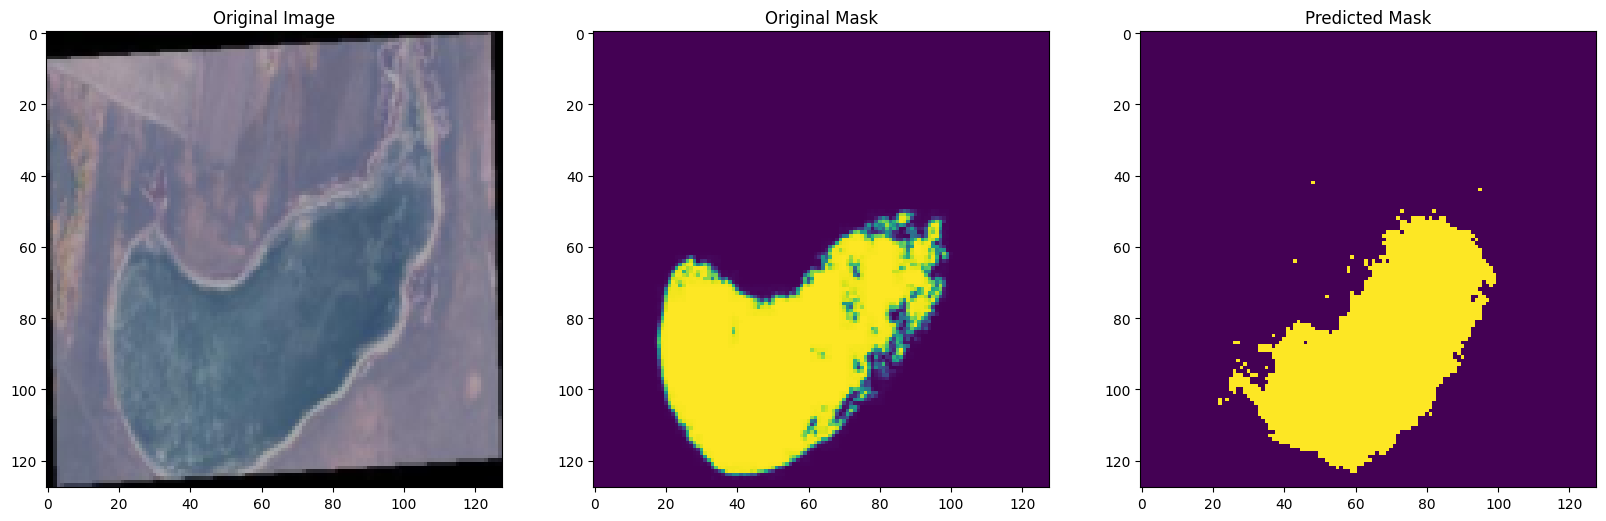

In [12]:
import random
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1, 3, figsize=(20,20))

rand_num = random.randint(0, images_val.shape[0])

original_img = images_val[rand_num]
original_img_transp = np.moveaxis(original_img, 0, -1)
original_img_transp = np.moveaxis(original_img_transp, 0, 1)
axes[0].imshow(original_img_transp)
axes[0].title.set_text('Original Image')

original_mask = masks_val[rand_num]
original_mask = original_mask.reshape(IMAGES_WITH, IMAGES_HEIGHT)
original_mask = np.moveaxis(original_mask, 0, -1)
axes[1].imshow(original_mask)
axes[1].title.set_text('Original Mask')

img = torch.from_numpy(np.array([original_img]))
img = img.to(device)
predicted_mask = model(img)[0]
predicted_mask = predicted_mask.cpu()
predicted_mask = predicted_mask.detach().numpy()
predicted_mask = predicted_mask.reshape(IMAGES_WITH, IMAGES_HEIGHT)
predicted_mask = np.moveaxis(predicted_mask, 0, 1)
predicted_mask[predicted_mask>0.5] = 1
predicted_mask[predicted_mask<=0.5] = 0
axes[2].imshow(predicted_mask)
axes[2].title.set_text('Predicted Mask')